In [43]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import Levenshtein
imp.reload(childes_db_phono)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


<module 'childes_db_phono' from '/home/stephan/notebooks/child-directed-listening/childes_db_phono.py'>

In [47]:
regenerate_cached_phono = False 
phono_data_path = 'csv/phono_data.csv'
if (not os.path.exists(phono_data_path)) or regenerate_cached_phono:
    phono = childespy.get_sql_query('select gloss, target_child_name, target_child_age, speaker_code, actual_phonology, model_phonology, transcript_id, corpus_name, collection_name, language from token where actual_phonology != "" and model_phonology != ""',
        db_version = "2020.1")
    # cache this phonological information locally
    phono.to_csv(phono_data_path, index=False)
else:
    phono = pd.read_csv(phono_data_path, keep_default_na=False, na_values=[''])

In [48]:
# remove cases where one is not set
phono = phono.loc[(phono.model_phonology != '*') & (phono.actual_phonology != '*')]

In [49]:
phono.shape

(914400, 10)

In [50]:
chi_phono = phono.loc[(phono.speaker_code == 'CHI') & (phono.target_child_age < (365*5))]

In [51]:
chi_phono.shape

(803100, 10)

In [52]:
chi_phono_age = chi_phono[['target_child_age']]
%R -i chi_phono_age

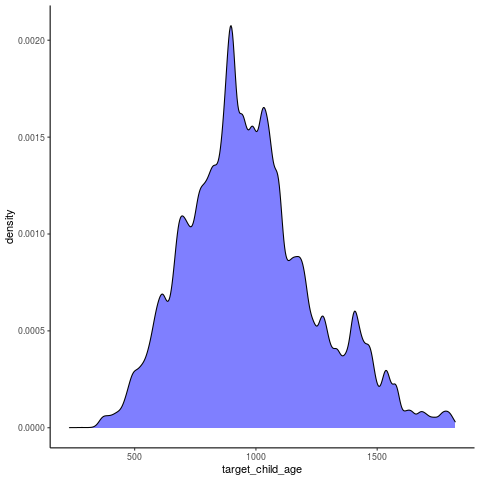

In [53]:
%%R
ggplot(chi_phono_age) + geom_density(aes(x=target_child_age), fill='blue', alpha=.5) + theme_classic()

In [63]:
def lev_wrapper(x,y):
    try: 
        dist = Levenshtein.distance(x,y)
        return(dist)
    except:
        print('Issue calculating Lev distance')
        print(x)
        print(y)
        return(None)

chi_phono['levdist'] = [lev_wrapper(x['actual_phonology'], x['model_phonology']) for x in  chi_phono.to_dict('records')]

/home/stephan/python/childespy/childesdb_client_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [64]:
chi_phono.columns

Index(['gloss', 'target_child_name', 'target_child_age', 'speaker_code',
       'actual_phonology', 'model_phonology', 'transcript_id', 'corpus_name',
       'collection_name', 'language', 'levdist'],
      dtype='object')

In [74]:
chi_mean_levdist = chi_phono.groupby(['transcript_id','corpus_name','collection_name','language',
                  'target_child_name','target_child_age']).levdist.agg(np.mean).reset_index()
chi_mean_levdist = chi_mean_levdist.rename(columns={'levdist': 'mean_levdist'})
chi_sd_levdist = chi_phono.groupby(['transcript_id','corpus_name','collection_name','language',
                  'target_child_name','target_child_age']).levdist.agg(np.std).reset_index()
chi_sd_levdist = chi_sd_levdist.rename(columns={'levdist': 'sd_levdist'})

In [75]:
chi_levdist = chi_mean_levdist.merge(chi_sd_levdist)
chi_levdist.head()

,transcript_id,corpus_name,collection_name,language,target_child_name,target_child_age,mean_levdist,sd_levdist
0,37458,MCF,Biling,por swe,Karin,243.5000,4.166667,1.940790
1,37459,MCF,Biling,por swe,Karin,273.9375,3.437500,1.931105
2,37460,MCF,Biling,por swe,Karin,334.8125,3.125000,1.552648
3,37461,MCF,Biling,swe por,Karin,608.7500,1.858974,1.345742
4,37462,MCF,Biling,swe por,Karin,639.1875,2.130435,1.324742


In [76]:
%R -i chi_levdist

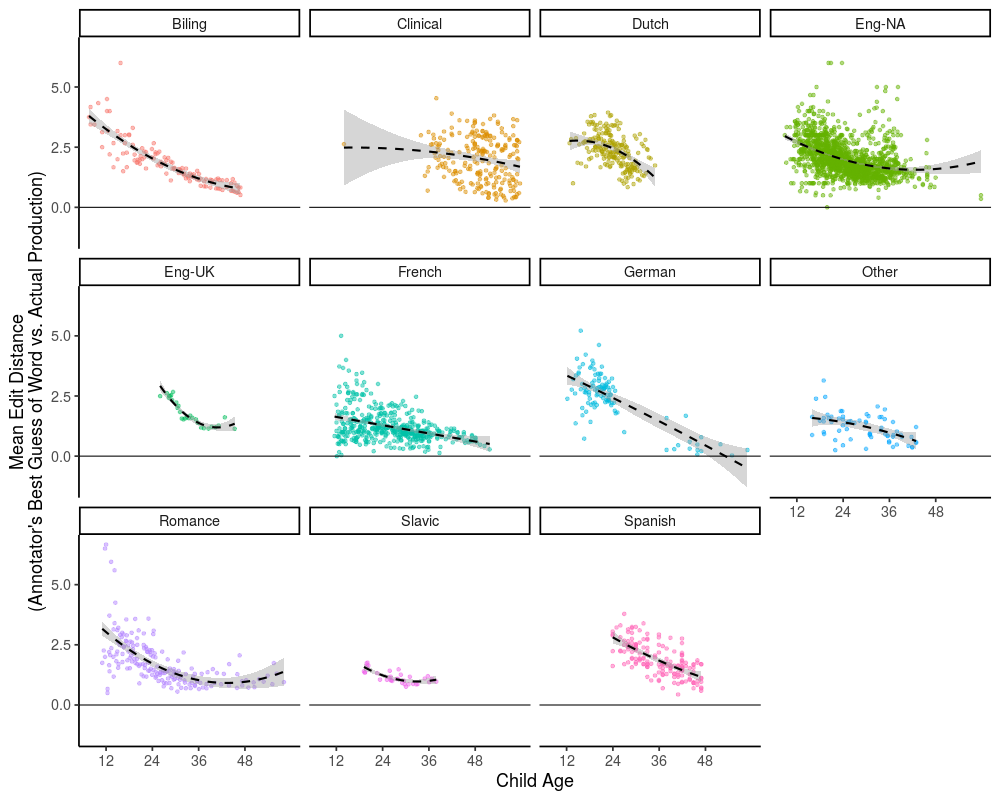

In [110]:
%%R -h 800 -w 1000
chi_levdist$age_in_months = chi_levdist$target_child_age / 30.5
year_intervals_in_months = c(12,24,36,48)

ggplot(subset(chi_levdist, mean_levdist < 100)) + geom_point(aes(x=age_in_months, y=mean_levdist, 
color=collection_name), alpha=.5)  + facet_wrap(~collection_name
) + theme_classic(base_size =18) +theme(legend.position="none"
) + geom_smooth(aes(x=age_in_months, y=mean_levdist), linetype='dashed', formula=y ~ poly(
    x, 2, raw=TRUE), method='lm', color='black') + ylab("Mean Edit Distance\n(Annotator's Best Guess of Word vs. Actual Production)"
) + xlab('Child Age') + geom_hline(yintercept =0) + scale_x_continuous(
    breaks = year_intervals_in_months, labels=year_intervals_in_months)

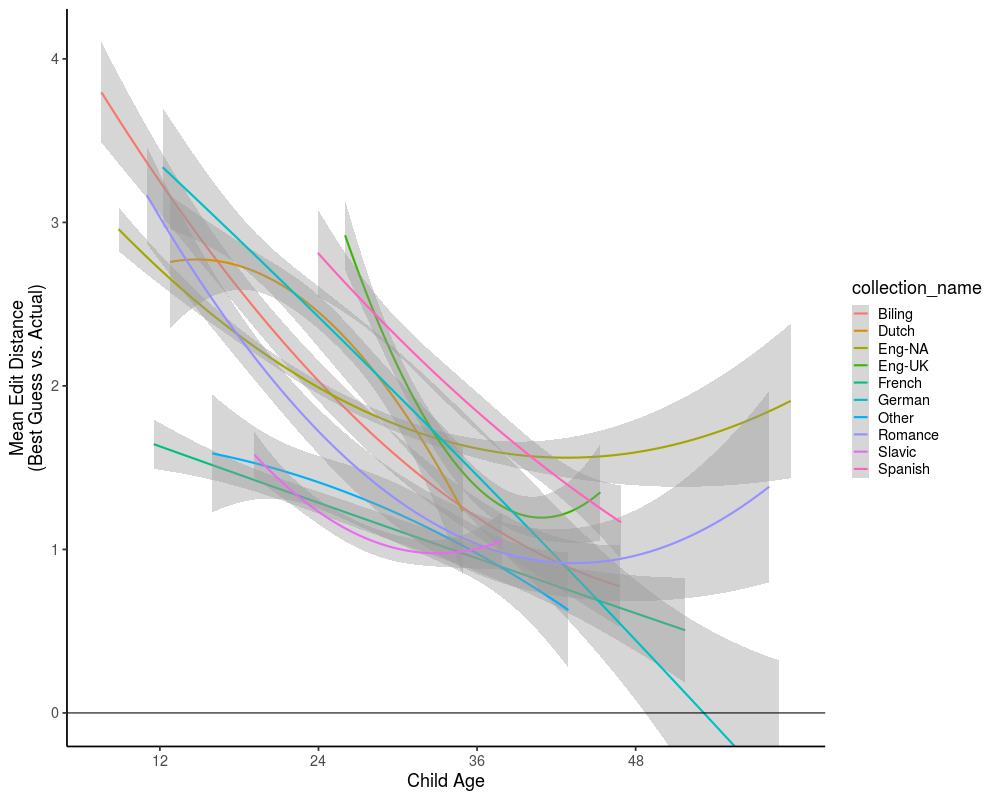

In [111]:
%%R -h 800 -w 1000
ggplot(subset(chi_levdist, mean_levdist < 100 & collection_name != "Clinical")) + theme_classic(
    base_size =18
)  + geom_smooth(aes(x=age_in_months, y=mean_levdist, 
color=collection_name), formula=y ~ poly(x, 2, raw=TRUE), method='lm'
) + ylab('Mean Edit Distance\n(Best Guess vs. Actual)') + xlab('Child Age'
) + scale_x_continuous(breaks = year_intervals_in_months, labels=year_intervals_in_months
) + geom_hline(yintercept =0) + coord_cartesian(ylim=c(0,4.1))

#+ geom_point(aes(x=target_child_age, y=mean_levdist, color=collection_name), alpha=.5)

In [ ]:
[ ] Try the PFST rather than unweighted Levenshtein distance